In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import pylab as pl
from sklearn.decomposition import PCA

import warnings #to ignore warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

# 1. Finding Similar Costumers

## 1.1 Set up the data

In [5]:
data=pd.read_csv('work/bank_transactions.csv')

In [6]:
data

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50
...,...,...,...,...,...,...,...,...,...
1048562,T1048563,C8020229,8/4/90,M,NEW DELHI,7635.19,18/9/16,184824,799.00
1048563,T1048564,C6459278,20/2/92,M,NASHIK,27311.42,18/9/16,183734,460.00
1048564,T1048565,C6412354,18/5/89,M,HYDERABAD,221757.06,18/9/16,183313,770.00
1048565,T1048566,C6420483,30/8/78,M,VISAKHAPATNAM,10117.87,18/9/16,184706,1000.00


For the sake of this first part, not all columns are necessary since comparing each field single handedly can be quite time-expensive. Then, carefully read the linked guide above and try to understand which features will be appropriate for this task (An heads up: some users have more than one transaction record, make sure to handle them all). Once you have finished, project a version of the dataset to work with.

## Examining the content of the dataset

## Setting dtype up

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


As we can see, *CustomerDOB*, *TransactionDate* and *TransactionTime* are object in this dataframe, let's handle it. 

In [8]:
#Let's convert TransactionDate to datetime, in order to get a date
data.TransactionDate = pd.to_datetime(data.TransactionDate) 

#Let's convert TransactionTime to datetime, in order to get the time 
def convert_time(value):
    sec = value % 100
    minutes = (value//100)%100
    hours = (value//10000)%100
    date = str(hours)+":"+str(minutes)+":"+str(sec)
    datetime_object = datetime.strptime(date,'%H:%M:%S').time()
    return datetime_object

#Let's apply the function
data['TransactionTime']=data.TransactionTime.apply(lambda row: convert_time(row))

# dt.normalize() basically sets all time component to 00:00:00, and it will only 
# display the date while keeping the datetime64 data format, thereby making it possible to do calculations with it.

data['TransactionTime']=pd.to_datetime(data['TransactionTime'], format='%H:%M:%S') - pd.to_datetime(data['TransactionTime'], format='%H:%M:%S').dt.normalize()

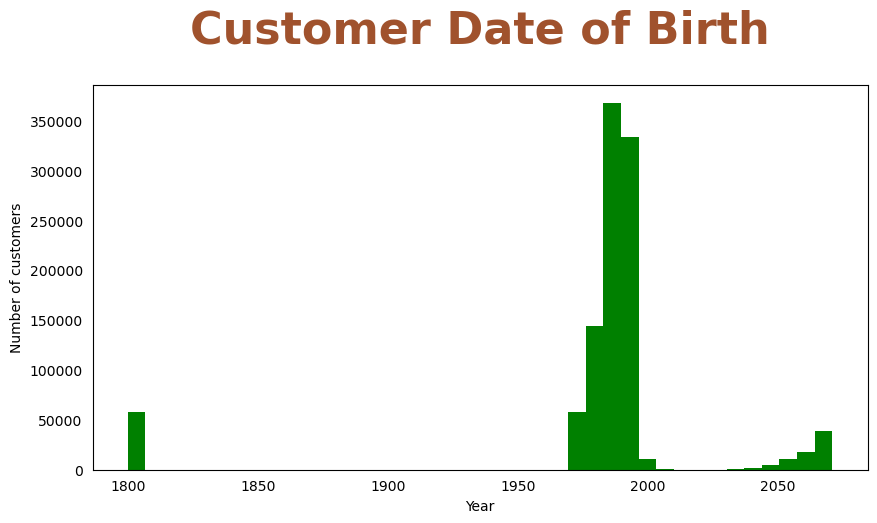

In [10]:
#Now let's handle CustomerDOB
data.CustomerDOB = pd.to_datetime(data.CustomerDOB) # fix date of birth

#Then let's visualize our data
plt.figure(figsize=(10,5))
pl.title("Customer Date of Birth",fontsize=32,fontweight='bold',color='sienna',pad=30)
pl.xlabel("Year")
pl.ylabel("Number of customers")
plt.hist(data.CustomerDOB.dt.year,bins=40,color="green")
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

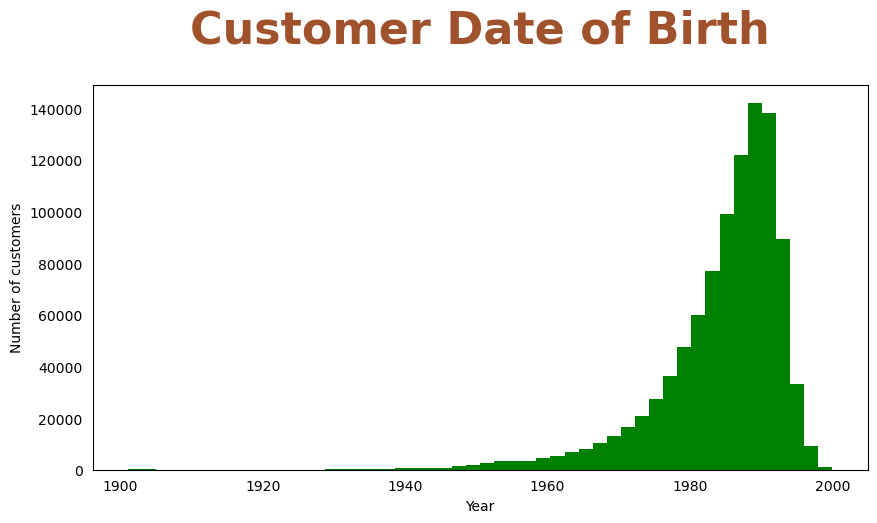

In [11]:
#There are some problems here, since the dataset is from 2016, we suppose valid only date of birth before 2000 and
# possibly, after 1900.

# Let's subtract 100 years to customers whose dob is above 2000
data.loc[data.CustomerDOB.dt.year >2000, 'CustomerDOB'] =  data.loc[data.CustomerDOB.dt.year >2000, 'CustomerDOB'] - pd.DateOffset(years = 100)

# Then let's drop data from customers whose dob is 1800
data.drop(data[data.CustomerDOB.dt.year == 1800].index, axis=0,inplace=True) 

#Let's visualize the result
plt.figure(figsize=(10,5))
pl.title("Customer Date of Birth",fontsize=32,fontweight='bold',color='sienna',pad=30)
pl.xlabel("Year")
pl.ylabel("Number of customers")
plt.hist(data.CustomerDOB.dt.year,bins=50,color="green")
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

In [12]:
#Let's use the CustomerDOB in order to create a new feature, the age of costumer
data['CustomerAge'] = (( pd.to_datetime('today') - data.CustomerDOB ) / np.timedelta64(1, 'Y')).round(0)

#Now let's drop all Nan so we can convert into integers
data.dropna(subset=['CustomerAge'],inplace=True)

#Then we convert them
data['CustomerAge'] = data['CustomerAge'].astype(int)

# Then let's drop data from customers age is greater than 100
data.drop(data[data.CustomerAge > 100].index, axis=0,inplace=True) 

In [13]:
# Perfect, now we have all the dtype ready to be used
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987117 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   TransactionID            987117 non-null  object         
 1   CustomerID               987117 non-null  object         
 2   CustomerDOB              987117 non-null  datetime64[ns] 
 3   CustGender               986966 non-null  object         
 4   CustLocation             986966 non-null  object         
 5   CustAccountBalance       984970 non-null  float64        
 6   TransactionDate          987117 non-null  datetime64[ns] 
 7   TransactionTime          987117 non-null  timedelta64[ns]
 8   TransactionAmount (INR)  987117 non-null  float64        
 9   CustomerAge              987117 non-null  int32          
dtypes: datetime64[ns](2), float64(2), int32(1), object(4), timedelta64[ns](1)
memory usage: 79.1+ MB


### Dealing with NAN values

In [14]:
#Let's see if there are any Nan in the dataset
data.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                   0
CustGender                  151
CustLocation                151
CustAccountBalance         2147
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
CustomerAge                   0
dtype: int64

In [15]:
for col in data.columns:
    print("Percentage of null values of {}:".format(col),str(np.round(data[col].isna().sum()/len(data)*100,2)) + '%')

Percentage of null values of TransactionID: 0.0%
Percentage of null values of CustomerID: 0.0%
Percentage of null values of CustomerDOB: 0.0%
Percentage of null values of CustGender: 0.02%
Percentage of null values of CustLocation: 0.02%
Percentage of null values of CustAccountBalance: 0.22%
Percentage of null values of TransactionDate: 0.0%
Percentage of null values of TransactionTime: 0.0%
Percentage of null values of TransactionAmount (INR): 0.0%
Percentage of null values of CustomerAge: 0.0%


In [16]:
# Since the percentage of Nan values in CustGender and CustLocation is smaller than 0.03%, we decide to drop them.

data.dropna(subset=['CustGender','CustLocation'], inplace = True)

#Taking into account CustAccountBalance, we can fill all the Nan values with the mean computed for every location and drop all the Nan values with no location

data.CustAccountBalance = data.CustAccountBalance.fillna(data.groupby('CustLocation')['CustAccountBalance'].transform('mean'))

data.dropna(subset=['CustAccountBalance'], inplace = True)

In [17]:
data.isnull().sum() #Better

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
CustomerAge                0
dtype: int64

### Checking columns

In [18]:
#Let's drop TransactionID since it is quite useless in our analysis
data.drop(['TransactionID'],axis=1,inplace=True)

In [19]:
#Then let's check CustGender
data['CustGender'].value_counts()

M    713387
F    273270
Name: CustGender, dtype: int64

In [20]:
#Let's rename TransactionAmount (INR) in TransactionAmount just for semplicity
data.rename(columns={'TransactionAmount (INR)':'TransactionAmount'},inplace=True)
data.head(1)

,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount,CustomerAge
0,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,0 days 14:32:07,25.00,28


In [21]:
#Let's create some new features like TransactionMonth, TransactionMonthName and TransactionDayName
data['TransactionMonth'] = data.TransactionDate.dt.month
data['TransactionMonthName'] = data.TransactionDate.dt.month_name()

data['TransactionDay'] = data.TransactionDate.dt.day
data['TransactionDayName'] = data.TransactionDate.dt.day_name()

data.drop('TransactionDate',axis=1,inplace=True) #we needed it only to get TransactionDayName

## Exploratory Data Analysis(EDA)

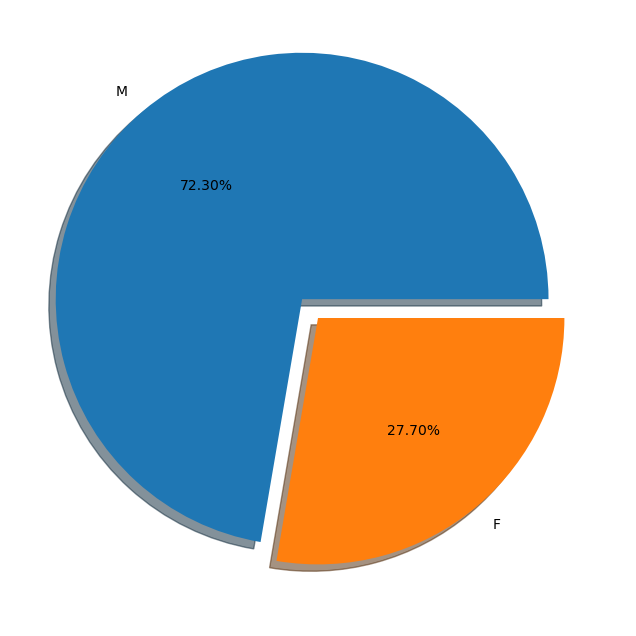

In [22]:
labels = data.CustGender.value_counts().keys()
values = data.CustGender.value_counts().values
explode = (0.1,0)

plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.2f%%');

A significant proportion of bank customers are males accounting for about 72% of the total share.

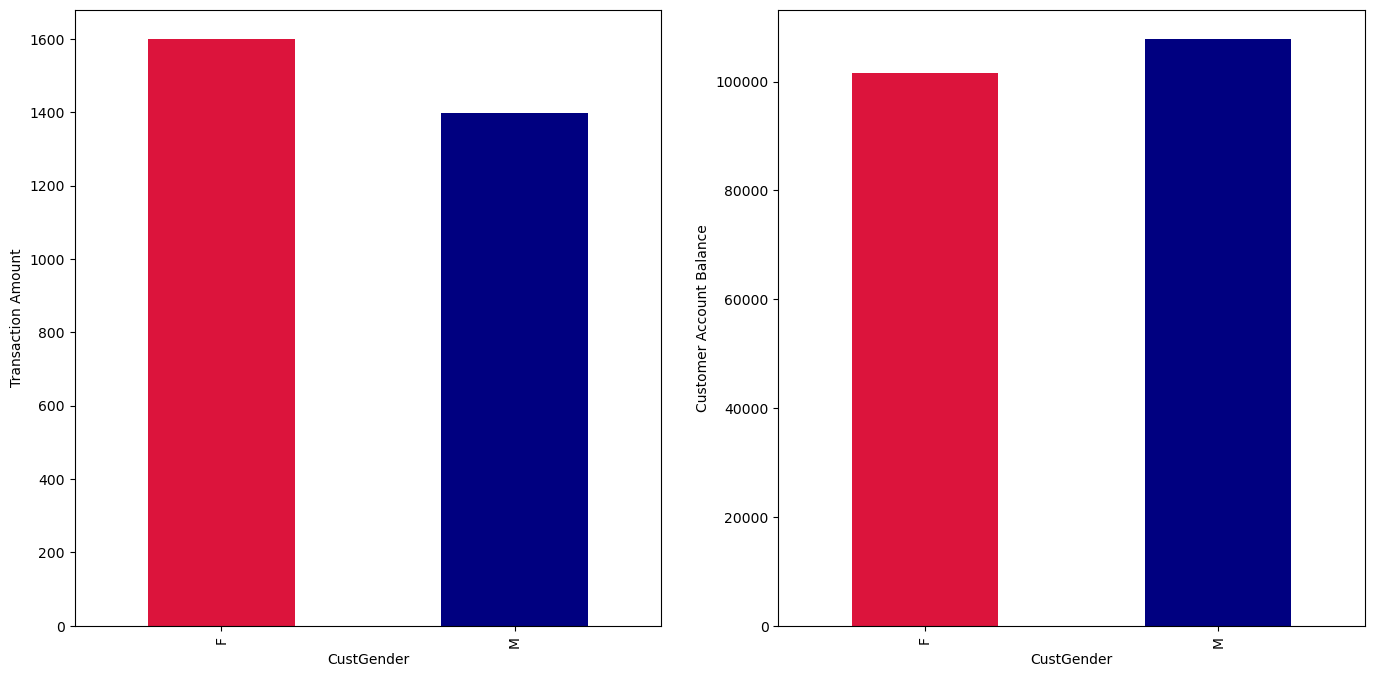

In [23]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplot(1, 2, 1)
ax1 = data.groupby('CustGender')['TransactionAmount'].mean().plot(kind='bar',color=['crimson','navy'])
plt.ylabel('Transaction Amount')

plt.subplot(1, 2, 2)
ax2 = data.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['crimson','navy'])
plt.ylabel('Customer Account Balance')
plt.subplots_adjust(right=1.2)
plt.show()

As we can see, male customers have, on average, marginally higher **account balances** in comparison to their female counterparts. On the other hand, females make ,on average, slightly higher **transactions** than males.

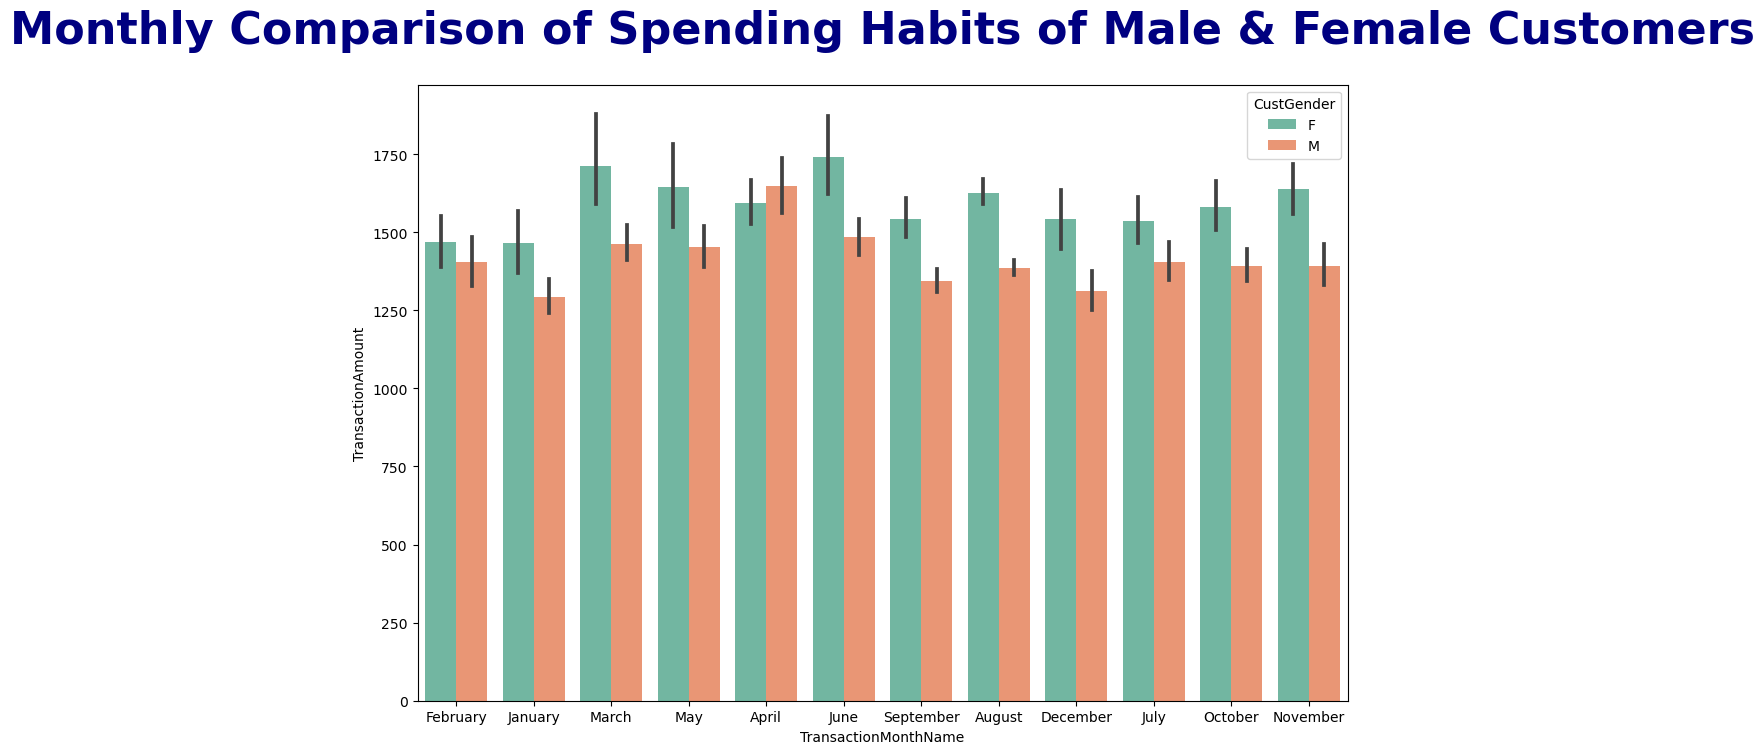

In [24]:
sns.barplot(data=data,x='TransactionMonthName',y='TransactionAmount',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Female customers make lower transactions than their male counterparts only during the months of February and April. In all the remaining months, male customers perform a lower amount of transactions. Higher value transactions are mostly done during the months of March, April and June. While the lower transaction are mostly done in January and February.

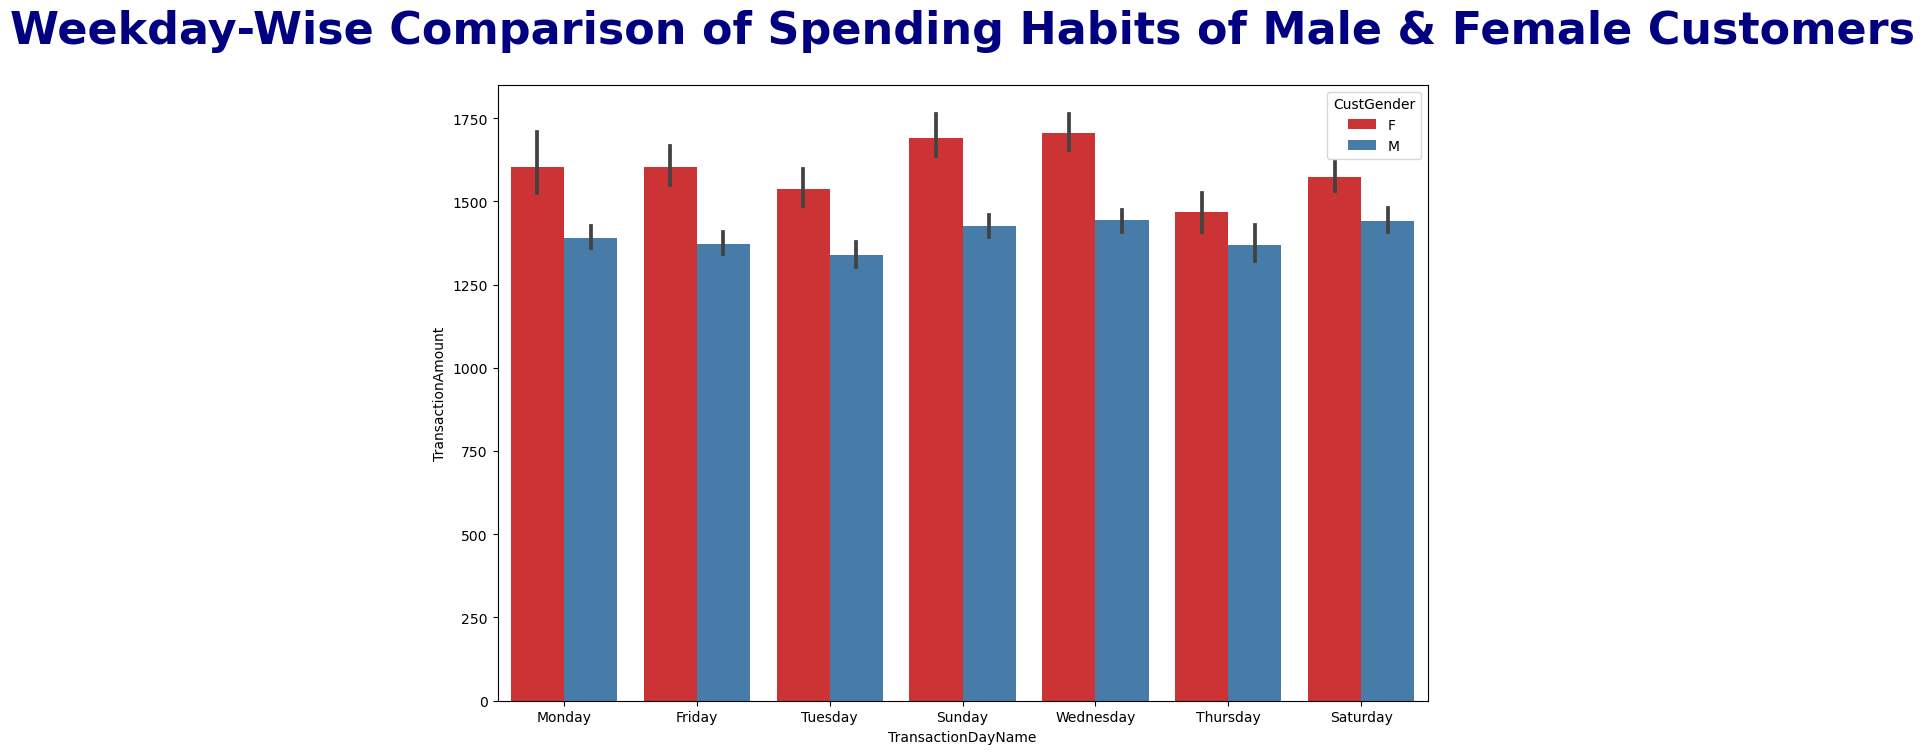

In [25]:
sns.barplot(data=data,x='TransactionDayName',y='TransactionAmount',palette='Set1',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30);

Female customers perform higher transactions than their male counterparts in almost every week day.

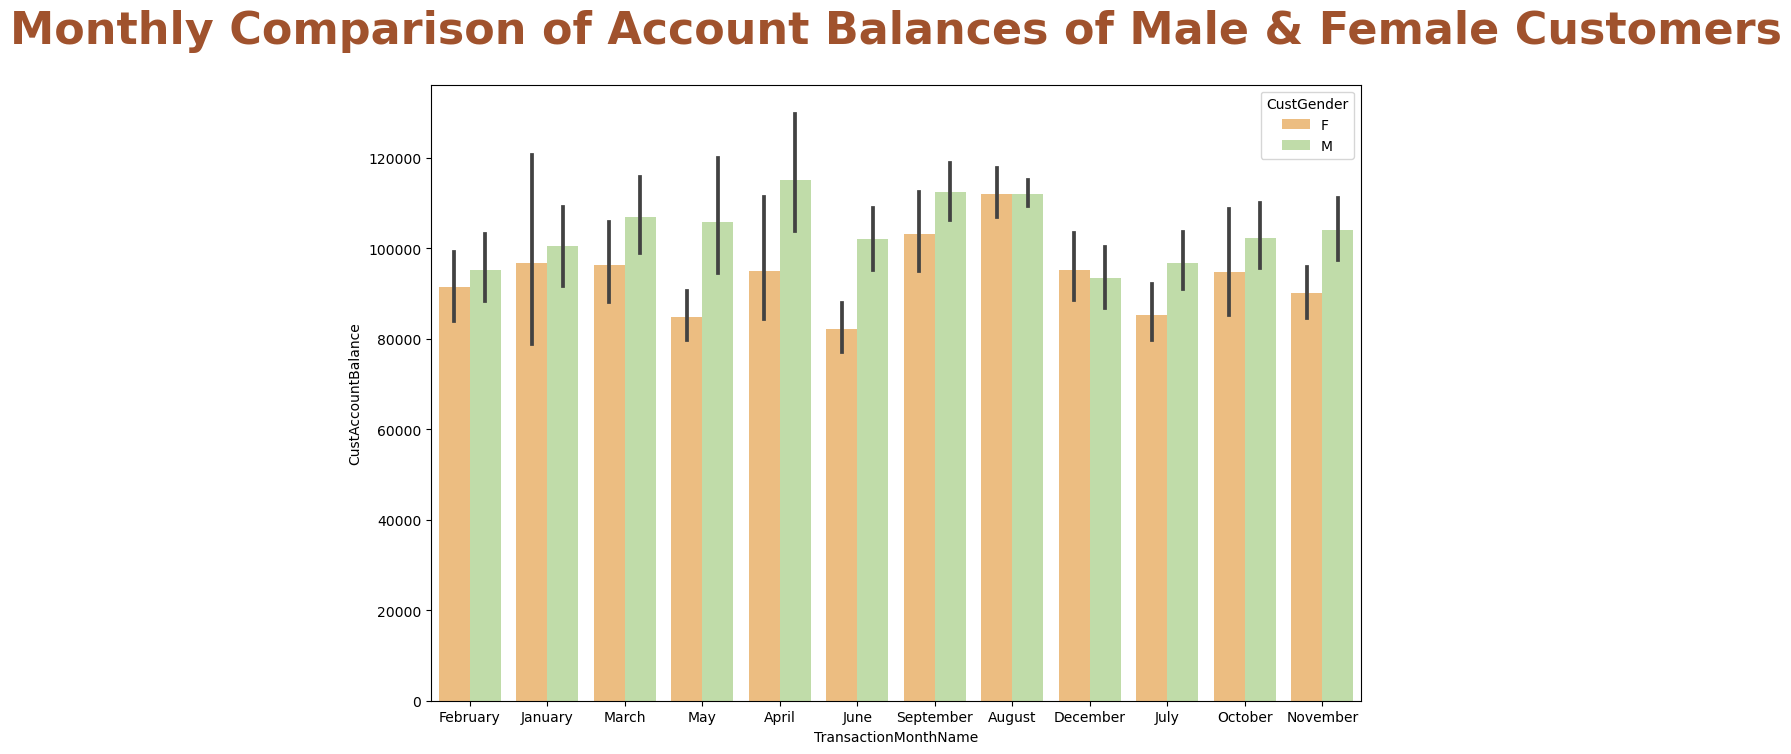

In [26]:
sns.barplot(data=data,x='TransactionMonthName',y='CustAccountBalance',palette='Spectral',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='sienna',pad=30);

Male customers generally have greater account balances as compared to their female counterparts. This is evident from the fact that they generally make comparatively low value transactions than female customers. The only month male account balances are equal to female account balances is August.

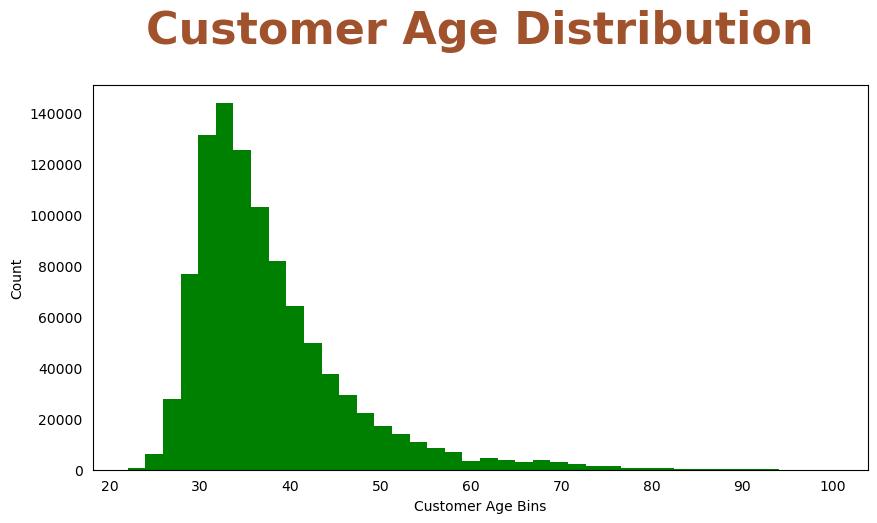

In [27]:
plt.figure(figsize=(10,5))
plt.title("Customer Age Distribution",fontsize=32,fontweight='bold',color='sienna',pad=30)
plt.xlabel("Customer Age Bins")
plt.ylabel("Count")
plt.hist(data.CustomerAge,bins=40,color="green")
plt.tick_params(bottom=False,left=False)
plt.ticklabel_format(style='plain')
plt.show()

We can see how customers with age up to 35 are in majority followed by 35 - 50.

In [29]:
data.to_pickle('work/bank.pkl')

# 2. Grouping customers together!

Now we will deal with clustering algorithms that will provide groups of clients which are similar among them

## 2.1 Getting your data + feature engineering

In [24]:
data=pd.read_pickle('work/bank.pkl')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986657 entries, 0 to 1048566
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype          
---  ------                --------------   -----          
 0   CustomerID            986657 non-null  object         
 1   CustomerDOB           986657 non-null  datetime64[ns] 
 2   CustGender            986657 non-null  object         
 3   CustLocation          986657 non-null  object         
 4   CustAccountBalance    986657 non-null  float64        
 5   TransactionTime       986657 non-null  timedelta64[ns]
 6   TransactionAmount     986657 non-null  float64        
 7   CustomerAge           986657 non-null  int32          
 8   TransactionMonth      986657 non-null  int64          
 9   TransactionMonthName  986657 non-null  object         
 10  TransactionDay        986657 non-null  int64          
 11  TransactionDayName    986657 non-null  object         
dtypes: datetime64[ns](1), float64(2), int32(1),

data Account Balance in USD

In [26]:
data['CustAccountBalance']=round(data['CustAccountBalance'] * 0.012,4)

In [27]:
data['TransactionAmount']= round(data['TransactionAmount'] * 0.012,4)

a) Number of transactions

In [28]:
#we create a dataset that contain for each customer id the number of transactions done
data2=data.groupby(['CustomerID','CustGender']).size().reset_index().rename(columns={0:'n_trans'})

b) Number of transactions with a balance bigger than 100 USD

In [29]:
#we create a second dataset with the customer who have done transaction highter then 100 and merge the two dataset
data4=data.loc[data['TransactionAmount']>100].groupby(['CustomerID','CustGender']).size().reset_index().rename(columns={0:'n_trans(>100)'})


In [30]:
#we filled the values nan with zeros because that are the customer id with no transaction highter then 100
d_features=pd.merge(left=data2, right=data4, how='outer', on=['CustomerID','CustGender'])
d_features['n_trans(>100)']=d_features['n_trans(>100)'].fillna(0).astype(int)

c) Average amount of the transactions

In [31]:
#we create a dataset that contain for each customer id the Average amount of the transactions and the we merge it with data_features
data3=data.groupby(['CustomerID','CustGender']).mean()['TransactionAmount'].reset_index().rename(columns={'TransactionAmount':'transaction_mean'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

d) Average balance

In [32]:
#we create a dataset that contain for each customer id the Average account balance and the we merge it with data_features
data3=data.groupby(['CustomerID','CustGender']).mean()['CustAccountBalance'].reset_index().rename(columns={'CustAccountBalance':'balance_mean'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).

In [33]:
data['Utilisation']=data['CustAccountBalance'] - data['TransactionAmount']
data3=data.groupby(['CustomerID','CustGender']).mean()['Utilisation'].reset_index().rename(columns={'Utilisation':'utilisation_mean'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

h) Most frequent location of the customer

In [34]:
data3=data.groupby(['CustomerID','CustGender'])['CustLocation'].agg(lambda x: pd.Series.mode(x)[0])

In [37]:
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

minimum Transaction amount for costumer

In [38]:
data3=data.groupby(['CustomerID','CustGender']).min()['TransactionAmount'].reset_index().rename(columns={'TransactionAmount':'min_transaction'})


In [39]:
d_features

,CustomerID,CustGender,n_trans,n_trans(>100),transaction_mean,balance_mean,utilisation_mean,CustLocation,min_transaction
0,C1010011,F,1,0,57.000,390.0088,333.0088,NOIDA,57.000
1,C1010011,M,1,0,4.272,1442.1665,1437.8945,NEW DELHI,4.272
2,C1010012,M,1,0,17.988,290.4539,272.4659,MUMBAI,17.988
3,C1010014,F,1,0,14.460,460.5257,446.0657,MUMBAI,14.460
4,C1010014,M,1,0,3.000,1942.1851,1939.1851,MUMBAI,3.000
...,...,...,...,...,...,...,...,...,...
894868,C9099836,M,1,0,8.292,1596.8068,1588.5148,BHIWANDI,8.292
894869,C9099877,M,1,0,2.664,1152.7615,1150.0975,BANGALORE,2.664
894870,C9099919,M,1,0,1.512,66.7170,65.2050,GUNTUR,1.512
894871,C9099941,M,1,0,0.600,423.5510,422.9510,CHENNAI,0.600


In [55]:
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

number of transaction less then 10 USD

In [40]:
data3=data.loc[data['TransactionAmount']<10].groupby(['CustomerID','CustGender']).size().reset_index().rename(columns={0:'n_transaction(<10)'})

In [41]:
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])
#we filled the value nan with zeros because that's are the customer id with no transaction smaller then 10
d_features['n_transaction(<10)']=d_features['n_transaction(<10)'].fillna(0).astype(int)

minimum Account Balance for each costumer

In [44]:
data3=data.groupby(['CustomerID','CustGender']).min()['CustAccountBalance'].reset_index().rename(columns={'CustAccountBalance':'min_acocunt_balance'})

In [48]:
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

Number of transaction on monday

In [53]:
data3=data.loc[data['TransactionDayName']=='Monday'].groupby(['CustomerID','CustGender']).size().reset_index().rename(columns={0:'transaction_Monday'})

In [54]:
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])
#we filled the value nan with zeros because that's are the customer id with no transaction smaller then 10
d_features['transaction_Monday']=d_features['transaction_Monday'].fillna(0).astype(int)

In [55]:
data3


,CustomerID,CustGender,transaction_Monday
0,C1010011,F,1
1,C1010028,F,1
2,C1010081,F,1
3,C1010113,F,1
4,C1010117,M,1
...,...,...,...
125312,C9098123,M,1
125313,C9098249,M,1
125314,C9098371,M,1
125315,C9098643,M,1


In [71]:
d_features['transaction_Monday']=d_features['transaction_Monday'].fillna(0).astype(int)

for each id transaction più recente e la prima transaction data.TransactoinDate.idxmax()

In [57]:
data3=data.loc[data['TransactionMonthName']=='December'].groupby(['CustomerID','CustGender']).size().reset_index().rename(columns={0:'transaction_December'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])
#we filled the value nan with zeros because that's are the customer id with no transaction smaller then 10
d_features['transaction_December']=d_features['transaction_December'].fillna(0).astype(int)

In [82]:
d_features

,CustomerID,CustGender,n_trans,n_trans(>100),transaction_mean,balance_mean,utilisation_mean,CustLocation,min_transaction,n_transaction(<10),min_acocunt_balance,transaction_Monday,transaction_December,n_transaction(>100.000),max_utilisation,max_acocunt_balance,max_transaction
0,C1010011,F,1,0,57.000,390.0088,333.0088,NOIDA,57.000,0,390.0088,1,0,0,333.0088,390.0088,57.000
1,C1010011,M,1,0,4.272,1442.1665,1437.8945,NEW DELHI,4.272,1,1442.1665,0,0,0,1437.8945,1442.1665,4.272
2,C1010012,M,1,0,17.988,290.4539,272.4659,MUMBAI,17.988,0,290.4539,0,0,0,272.4659,290.4539,17.988
3,C1010014,F,1,0,14.460,460.5257,446.0657,MUMBAI,14.460,0,460.5257,0,0,0,446.0657,460.5257,14.460
4,C1010014,M,1,0,3.000,1942.1851,1939.1851,MUMBAI,3.000,1,1942.1851,0,0,0,1939.1851,1942.1851,3.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894868,C9099836,M,1,0,8.292,1596.8068,1588.5148,BHIWANDI,8.292,1,1596.8068,0,0,0,1588.5148,1596.8068,8.292
894869,C9099877,M,1,0,2.664,1152.7615,1150.0975,BANGALORE,2.664,1,1152.7615,0,0,0,1150.0975,1152.7615,2.664
894870,C9099919,M,1,0,1.512,66.7170,65.2050,GUNTUR,1.512,1,66.7170,0,0,0,65.2050,66.7170,1.512
894871,C9099941,M,1,0,0.600,423.5510,422.9510,CHENNAI,0.600,1,423.5510,0,0,0,422.9510,423.5510,0.600


Transaction grater than 100.000

In [59]:
data3=data.loc[data['TransactionAmount']>100000].groupby(['CustomerID','CustGender']).size().reset_index().rename(columns={0:'n_transaction(>100.000)'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])
#we fill the nan values with zeros because that are customer id with no transaction higher than 100.000


In [60]:
d_features['n_transaction(>100.000)']=d_features['n_transaction(>100.000)'].fillna(0).astype(int)

Maximum Utilisation for costumer

In [62]:
data3=data.groupby(['CustomerID','CustGender']).max()['Utilisation'].reset_index().rename(columns={'Utilisation':'max_utilisation'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

Maximum Account Balance for costumer

In [64]:
data3=data.groupby(['CustomerID','CustGender']).max()['CustAccountBalance'].reset_index().rename(columns={'CustAccountBalance':'max_acocunt_balance'})
#merge the dataframe
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

Maximum transaction amount for costumer

In [66]:
data3=data.groupby(['CustomerID','CustGender']).max()['TransactionAmount'].reset_index().rename(columns={'TransactionAmount':'max_transaction'})
d_features=pd.merge(left=d_features, right=data3, how='outer', on=['CustomerID','CustGender'])

In [68]:
d_features.to_pickle('work/d_features.pkl')

In [69]:
d_features.to_csv('work/d_features.csv')

## 2.2 Choose your features (variables)!

Normalization is important in PCA since it is a variance maximizing exercise. It projects your original data onto directions which maximize the variance.

In [94]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import seaborn as sns
sns.set()

In [71]:
d_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 894873 entries, 0 to 894872
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CustomerID               894873 non-null  object 
 1   CustGender               894873 non-null  object 
 2   n_trans                  894873 non-null  int64  
 3   n_trans(>100)            894873 non-null  int32  
 4   transaction_mean         894873 non-null  float64
 5   balance_mean             894873 non-null  float64
 6   utilisation_mean         894873 non-null  float64
 7   CustLocation             894873 non-null  object 
 8   min_transaction          894873 non-null  float64
 9   n_transaction(<10)       894873 non-null  int32  
 10  min_acocunt_balance      894873 non-null  float64
 11  transaction_Monday       894873 non-null  int32  
 12  transaction_December     894873 non-null  int32  
 13  n_transaction(>100.000)  894873 non-null  int32  
 14  max_

We want to treat all the features equally. And we can achieve that by transforming the features in a way that makes their values fall within the same numerical range. Thus, the differences between their values will be comparable. This process is commonly referred to as standardization.

In [99]:
col_normalize=['n_trans','n_trans(>100)','transaction_mean','balance_mean','utilisation_mean','min_transaction','n_transaction(<10)','min_acocunt_balance','transaction_Monday','transaction_December','n_transaction(>100.000)','max_utilisation','max_acocunt_balance','max_transaction']
data_features2=StandardScaler().fit_transform(d_features[col_normalize].to_numpy())

data_features2= pd.DataFrame(data_features2, columns=col_normalize)

In [100]:
pca = PCA()
pca.fit(data_features2)

PCA()

In [102]:
#the attribute show how much variance is explaned by each of the component
cumulatevariance=np.cumsum(pca.explained_variance_ratio_)
cumulatevariance

array([0.37608024, 0.63406578, 0.74393806, 0.82612952, 0.89479875,
       0.94412228, 0.98336911, 0.9945814 , 0.99989351, 0.99995374,
       0.99999994, 1.        , 1.        , 1.        ])

Text(0, 0.5, 'Comulative explained variance')

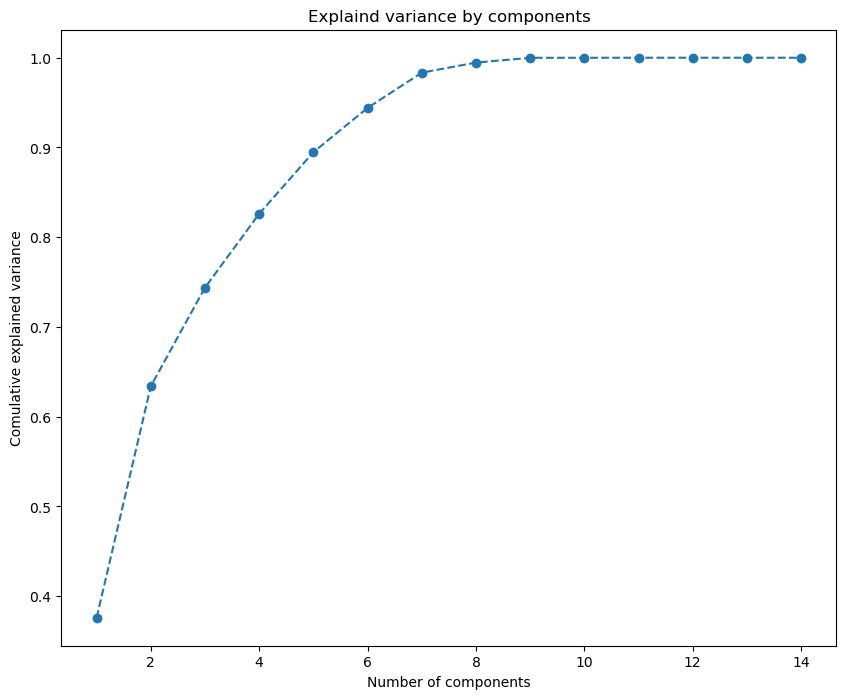

In [83]:
plt.figure(figsize=(10,8))
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle='--')
plt.title('Explaind variance by components')
plt.xlabel('Number of components')
plt.ylabel('Comulative explained variance')

The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). to preserve more than 70% of the variance we decide to keep 3 components.

In [84]:
#we coohse the number of components
pca = PCA()
pca.fit(data_features2)

PCA()

In [85]:
scores_pca=pca.transform(data_features2)

## 2.3 Clustering!

Based on the values of the WCSS and an approach known as the Elbow method, we make a decision about how many clusters we’d like to keep.

In [86]:
wcss=[]
for i in range(1,11):
    kmeans_pca=KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

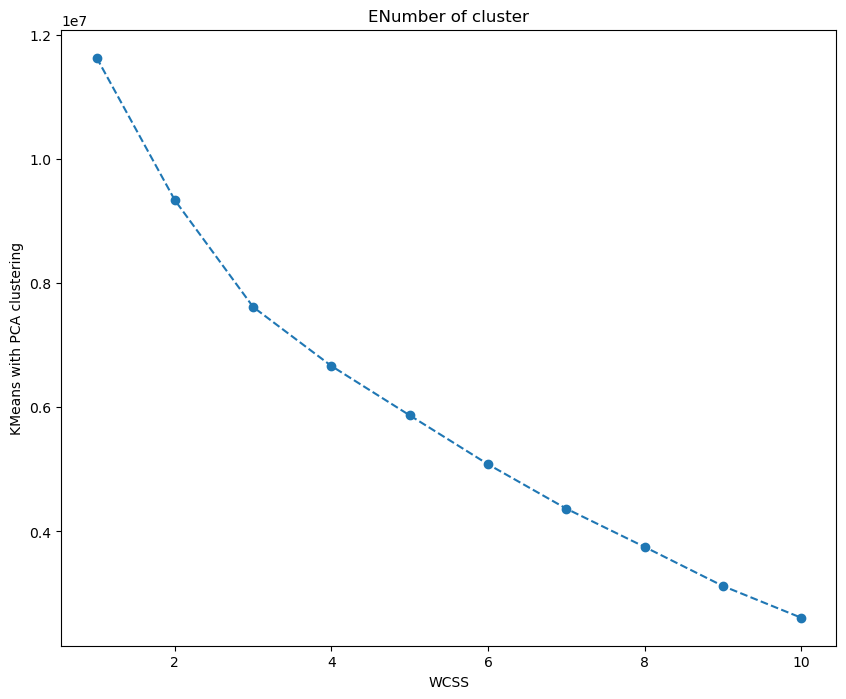

In [88]:
plt.figure(figsize=(10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle='--')
plt.title('ENumber of cluster')
plt.xlabel('WCSS')
plt.ylabel('KMeans with PCA clustering')
plt.show()

From this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method.

In [89]:
kmeans_pca=KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

In [93]:
data_pKMeans=pd.concat([d_features.reset_index(drop=True), pd.DataFrame(scores_pca)], axis=1)
data_pKMeans.columns.values[-3:]=['Component1','Component2', 'Component3'] 
data_pKMeans['n_cluster']=kmeans_pca.labels_


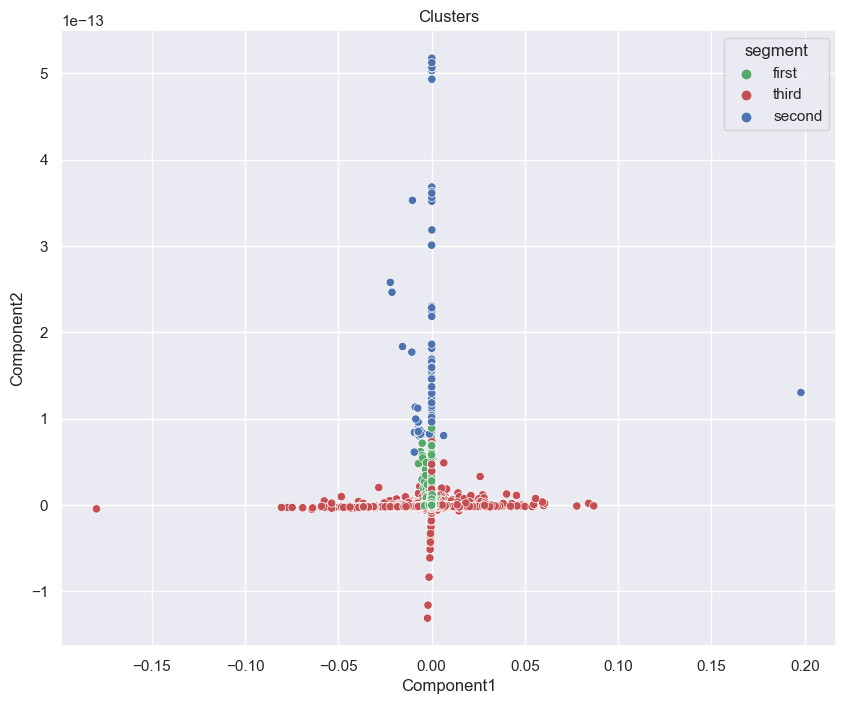

In [98]:
data_pKMeans['segment']=data_pKMeans['n_cluster'].map({0:'first',1:'second',2:'third'})
x_axis=data_pKMeans['Component1']
y_axis=data_pKMeans['Component2']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis, hue=data_pKMeans['segment'],palette=['g','r','b'])
plt.title('Clusters')
plt.show()

In [141]:
i=0
h=[]
while i<4:
    s=list(np.random.permutation(4))
    if s not in h:
        h.append(s)
        i+=1

print(h)


[[2, 1, 3, 0], [1, 3, 2, 0], [2, 0, 3, 1], [2, 3, 0, 1]]


In [154]:
m=[[1,1,0,1,0,1], 
   [1,0,0,0,1,0],
   [1,1,1,0,0,0],
   [0,0,0,0,0,1]]



In [4]:
data_features.head()

,CustomerID,n_trans,n_trans(100),trans_mean,balance_mean,util_mean,CustLocation
0,C1010011,2,2.0,2553.0,76340.635,73787.635,NEW DELHI
1,C1010012,1,1.0,1499.0,24204.490,22705.490,MUMBAI
2,C1010014,2,2.0,727.5,100112.950,99385.450,MUMBAI
3,C1010018,1,1.0,30.0,496.180,466.180,CHAMPARAN
4,C1010024,1,1.0,5000.0,87058.650,82058.650,KOLKATA


In [5]:
class Point:
    def __init__(self, line):
        values = line.split(",")
        self.components = np.array([round(float(k), 5) for k in values])
        self.number_of_points = 1

    def sum(self, p):
        self.components = np.add(self.components, p.components)
        self.number_of_points += p.number_of_points
        return self

    def distance(self, p, h):
        if (h < 0):
           h = 2
        return linalg.norm(self.components - p.components, h)

    def get_average_point(self):
        self.components = np.around(np.divide(self.components, self.number_of_points), 5)
        return self

In [12]:
pip install pyspark

  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845525 sha256=55c071f11a20f564bda38700b5531ff6363d2b4ed38e406134f886de4ae552c3
  Stored in directory: c:\users\soph\appdata\local\pip\cache\wheels\51\c8\18\298a4ced8ebb3ab8a7d26a7198c0cc7035abb906bde94a4c4b
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pyspark.sql import SparkSession 
import time

In [12]:
import os

# Set spark environments
os.environ['PYSPARK_PYTHON'] = r'C:\Users\soph\AppData\Local\Microsoft\WindowsApps\python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = r'C:\Users\soph\AppData\Local\Microsoft\WindowsApps\python3'

In [39]:
spark= SparkSession.builder.config("spark.network.timeout","50s").config("spark.executor.heartbeatInterval", "50s").config("spark.network.timeout", 88000000).getOrCreate()
sc = spark.sparkContext

In [7]:
def init_centroids(dataset, k):
    start_time = time.time()
    initial_centroids = dataset.takeSample(False, k)
    print("init centroid execution:", len(initial_centroids), "in", (time.time() - start_time), "s")
    return initial_centroids

In [ ]:
while True:
    print("--Iteration n. {itr:d}".format(itr=n+1), end="\r", flush=True)
    cluster_assignment_rdd = points.map(assign_centroids)
    sum_rdd = cluster_assignment_rdd.reduceByKey(lambda x, y: x.sum(y))
    centroids_rdd = sum_rdd.mapValues(lambda x: x.get_average_point()).sortByKey(ascending=True)

    new_centroids = [item[1] for item in centroids_rdd.collect()]
    stop = stopping_criterion(new_centroids,parameters["threshold"])

    n += 1
    if(stop == False and n < parameters["maxiteration"]):
        centroids_broadcast = sc.broadcast(new_centroids)
    else:
        break

In [6]:
def stopping_criterion(new_centroids, threshold):
    old_centroids = centroids_broadcast.value
    for i in range(len(old_centroids)):
        check = old_centroids[i].distance(new_centroids[i], distance_broadcast.value) <= threshold
        if check == False:
            return False
    return True

In [9]:
def assign_centroids(p):
    min_dist = float("inf")
    centroids = centroids_broadcast.value
    nearest_centroid = 0
    for i in range(len(centroids)):
        distance = p.distance(centroids[i], distance_broadcast.value)
        if(distance < min_dist):
            min_dist = distance
            nearest_centroid = i
    return (nearest_centroid, p)

In [16]:
print( "spark version=" ,SparkSession.builder.appName("test").getOrCreate().version)

spark version= 3.3.1


In [2]:
data= pd.read_pickle('work/data_features.pkl')

In [5]:
data.head()

,n_trans,n_trans(>100),transaction_mean,balance_mean
0,1,0,57.000,390.0088
1,1,0,4.272,1442.1665
2,1,0,17.988,290.4539
3,1,0,14.460,460.5257
4,1,0,3.000,1942.1851


In [22]:
col=['CustomerID','CustGender']
data.drop(col,inplace=True,axis=1)

In [6]:
data.to_pickle('work/prova.pkl')

In [7]:
data.to_csv('work/prova.csv')

In [12]:
data.to_csv('work/prova2.csv', header=False)

In [19]:
data=pd.read_pickle('work/data_features.pkl')

In [20]:
data

,CustomerID,CustGender,n_trans,n_trans(>100),transaction_mean,balance_mean
0,C1010011,F,1,0,57.000,390.0088
1,C1010011,M,1,0,4.272,1442.1665
2,C1010012,M,1,0,17.988,290.4539
3,C1010014,F,1,0,14.460,460.5257
4,C1010014,M,1,0,3.000,1942.1851
...,...,...,...,...,...,...
894868,C9099836,M,1,0,8.292,1596.8068
894869,C9099877,M,1,0,2.664,1152.7615
894870,C9099919,M,1,0,1.512,66.7170
894871,C9099941,M,1,0,0.600,423.5510
